<figure>
<center>
<img src='https://drive.google.com/uc?export=view&id=18JwHT8YDIJhm1Of7wvk65XdVfWxcg4af' width="200" />
<figcaption></figcaption></center>
</figure>

# ***Resolución de problemas directos e inversos de ecuaciones diferenciales mediante técnicas de deep learning***

**Practicantes:** Fernando Fêtis y Diego Olguín. 

**Supervisor:** Hugo Carrillo.


In [1]:
#@title Librerías

from shapely.affinity import affine_transform
from shapely.geometry import Point, Polygon
from shapely.ops import triangulate
from shapely.prepared import prep

import shapely 
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable

import random

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from scipy import stats

from matplotlib.animation import FuncAnimation

In [2]:
#@title Generación de mallas poligonales

class PolygonMesh:

  def __init__(self, vertices):

    P = shapely.Polygon(vertices)

    self.vertices = vertices
    self.geometry = shapely.geometry.polygon.orient(P)
    self.edges = self._get_edges()
    self.normals = {}
    self.samples = {}
    self.interior_subdomains = {}
    self.boundary_subdomains = {}

  def _get_edges(self):
    edges = []
    N_edges = len(self.geometry.boundary.coords)

    for i in range(N_edges-1):
      (x0, y0), (x1, y1) = self.geometry.boundary.coords[i], self.geometry.boundary.coords[i+1]
      edges.append([(x0, y0), (x1, y1)])
    
    return edges

  def add_interior_subdomain(self, subdomain, name=""):
    keys = self.interior_subdomains.keys()
    if name=="":
      name = "int"+str(len(keys)+1)
    elif name=="res":
      name = "int"+str(len(keys)+1)
      print("'res' is not a valid name for subdomain, instead using "+name)

    self.interior_subdomains[name] = subdomain
  

  def add_boundary_subdomain(self, subdomain, name=""):
    keys = self.boundary_subdomains.keys()
    if name=="":
      name = "int"+str(len(keys)+1)
    elif name=="res":
      name = "int"+str(len(keys)+1)
      print("'res' is not a valid name for subdomain, instead using "+name)

    self.boundary_subdomains[name] = subdomain


  def sample_interior(self, k_samples):

    if self.interior_subdomains != {}:
      k = sum(k_samples.values())
      self.samples['interior'] = {}

      i_points = {}

      for key in self.interior_subdomains.keys():
        i_points[key] = []

      i_points['res'] = []

      T = triangulate(self.geometry)
      triangs = [t for t in T if self.geometry.contains(t)]

      areas = []
      transforms = []
      for t in triangs:
          areas.append(t.area)
          (x0, y0), (x1, y1), (x2, y2), _ = t.exterior.coords
          transforms.append([x1 - x0, x2 - x0, y1 - y0, y2 - y0, x0, y0])

      for transform in random.choices(transforms, weights=areas, k=k):
          x, y = np.random.random(2)
          if x + y > 1:
            x, y = 1 - x, 1 - y 
            p = Point(x, y)
          else:
            p = Point(x, y)

          t_point = affine_transform(p, transform)
            
          xn, yn = t_point.coords.xy[0][0], t_point.coords.xy[1][0]
          bound = 'res'

          for key in self.interior_subdomains.keys():
            if self.interior_subdomains[key](xn, yn):
              if len(i_points[key]) < k_samples[key]:
                bound = key
              else:
                bound = ''

            if bound != '':
              i_points[bound].append(t_point)

      for key in self.interior_subdomains.keys():
        points = i_points[key]
        torch_points = torch.tensor([p.coords for p in points]).reshape(-1, 2).T
        self.samples['interior'][key] = torch_points

      torch_points = torch.tensor([p.coords for p in i_points['res']]).reshape(-1, 2).T
      self.samples['interior']['res'] = torch_points

    else:
      k = k_samples

      T = triangulate(self.geometry)
      triangs = [t for t in T if self.geometry.contains(t)]

      areas = []
      transforms = []
      points = []
      for t in triangs:
          areas.append(t.area)
          (x0, y0), (x1, y1), (x2, y2), _ = t.exterior.coords
          transforms.append([x1 - x0, x2 - x0, y1 - y0, y2 - y0, x0, y0])
      
      for transform in random.choices(transforms, weights=areas, k=k):
          x, y = np.random.random(2)
          if x + y > 1:
              p = Point(1 - x, 1 - y)
          else:
              p = Point(x, y)

          points.append(affine_transform(p, transform))

      torch_points = torch.tensor([p.coords for p in points]).reshape(-1, 2).T

      self.samples['interior'] = {'res': torch_points}

    return self.samples['interior']


  def sample_boundary(self, k_samples):

    if self.boundary_subdomains != {}:
      k = sum(k_samples.values())

      b_points, lengths, edges = {}, [], []
      N_edges = len(self.geometry.boundary.coords)

      for key in self.boundary_subdomains.keys():
        b_points[key] = []

      b_points['res'] = []

      for i in range(N_edges-1):
        (x0, y0), (x1, y1) = self.geometry.boundary.coords[i], self.geometry.boundary.coords[i+1]
        lengths.append(np.sqrt((x1-x0)**2 + (y1-y0)**2))
        edges.append([(x0, y0), (x1, y1)])

      for edge in random.choices(edges, weights=lengths, k=k):
        lambd = np.random.random()
        (x0, y0), (x1, y1) = edge
        xn, yn = (1-lambd)*x0 + lambd*x1, (1-lambd)*y0 + lambd*y1

        bound = 'res'

        for key in self.boundary_subdomains.keys():
          if self.boundary_subdomains[key](xn, yn):
            if len(b_points[key]) < k_samples[key]:
              bound = key
            else:
              bound = ''

        if bound != '':
          b_points[bound].append(Point(xn, yn))

      self.samples['boundary'] = {}

      for key in self.boundary_subdomains.keys():

        torch_points = torch.tensor([p.coords for p in b_points[key]]).reshape(-1, 2).T
        self.samples['boundary'][key] = torch_points
        self.normals[key] = self._normal_vector(torch_points[0], torch_points[1])

      torch_points = torch.tensor([p.coords for p in b_points['res']]).reshape(-1, 2).T
      self.samples['boundary']['res'] = torch_points
      self.normals['res'] = self._normal_vector(torch_points[0], torch_points[1])
      
    else:
      k = k_samples 

      b_points, lengths, edges = [], [], []
      N_edges = len(self.geometry.boundary.coords)

      for i in range(N_edges-1):
        (x0, y0), (x1, y1) = self.geometry.boundary.coords[i], self.geometry.boundary.coords[i+1]
        lengths.append(np.sqrt((x1-x0)**2 + (y1-y0)**2))
        edges.append([(x0, y0), (x1, y1)])

      for edge in random.choices(edges, weights=lengths, k=k):
        lambd = np.random.random()
        (x0, y0), (x1, y1) = edge
        b_points.append(Point((1-lambd)*x0 + lambd*x1, (1-lambd)*y0 + lambd*y1))

      torch_points = torch.tensor([p.coords for p in b_points]).reshape(-1, 2).T

      self.samples['boundary'] = {'res': torch_points}

      self.normals['res'] = self._normal_vector(torch_points[0], torch_points[1])

    return self.samples['boundary']


  def plot_samples(self):

    if self.samples == {}:
      print("No samples to plot. Generate samples first.")

    else:
      if 'interior' in self.samples.keys():
        for key in self.samples['interior'].keys():
          plt.plot(*self.samples['interior'][key], '.', label=key)

      if 'boundary' in self.samples.keys():
        for key in self.samples['boundary'].keys():
          plt.plot(*self.samples['boundary'][key], '.', label=key)

      plt.legend()
      plt.show()   


  def plot(self):
    x = np.array(self.geometry.exterior.coords.xy[0])
    y = np.array(self.geometry.exterior.coords.xy[1])

    plt.fill(x,y, facecolor='lightblue', edgecolor='blue')
    plt.show()


  def _normal_vector(self, x, y, tol=1e-3):
    E = self.edges
    N = len(E)

    normals = torch.zeros((len(x), 2))

    for i in range(len(x)):

      con_edge = torch.zeros(2)
      xi, yi = x[i], y[i]

      for j in range(N):
        edge = shapely.LineString(E[j])
        buf = edge.buffer(tol)
        if buf.contains(Point(xi.item(), yi.item())):
          con_edge = torch.tensor(E[j][1]) - torch.tensor(E[j][0])

      if torch.dot(con_edge, con_edge)==0:
        print("Point not in boundary or Point it's a vertex")
        n = torch.zeros(2)

      elif con_edge[0].item() == 0:
        n = torch.tensor([1., 0.])
        n *= torch.sign(n[0]*con_edge[1] - n[1]*con_edge[0])

      else:
        e1 = torch.tensor([0., 1.])
        n = e1 - torch.dot(e1, con_edge)/torch.dot(con_edge, con_edge) * con_edge 
        n *= torch.sign(n[0]*con_edge[1] - n[1]*con_edge[0])/torch.linalg.norm(n)

      normals[i] = n

    return normals.reshape(2, len(x))


  def grid(self, step):

    latmin, lonmin, latmax, lonmax = self.geometry.bounds
    prep_polygon = prep(self.geometry)

    points = []
    for lat in np.arange(latmin, latmax, step):
        for lon in np.arange(lonmin, lonmax, step):
            points.append(Point((round(lat,4), round(lon,4))))

    valid_points = []
    valid_points.extend(filter(prep_polygon.contains, points))

    grid_coords = torch.tensor([p.coords for p in valid_points]).reshape(-1, 2)

    x, y = grid_coords.T

    return x, y

In [3]:
def unif_square(samples, x1=0, x2=1, x3=0, x4=1):
  arr_samples = np.zeros((2, samples))
  for i in range(samples):
    arr_samples[:, i] = x1 + (x2 - x1)*np.random.rand(), x3 + (x4 - x3)*np.random.rand()

  return arr_samples

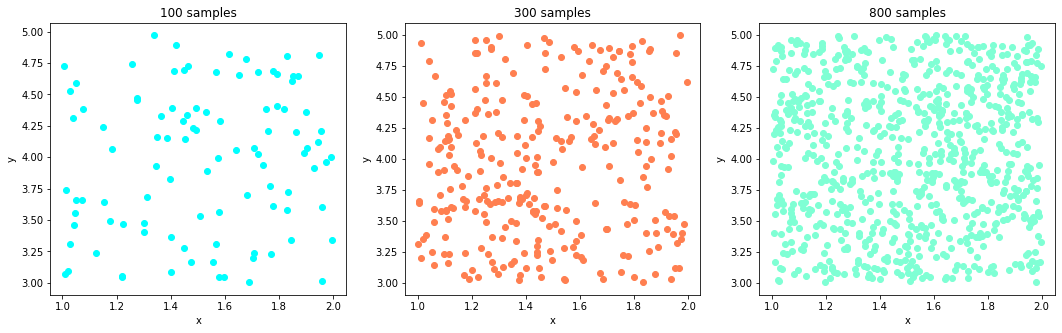

In [4]:
num_samples = (100, 300, 800)
colors = ("aqua", "coral", "aquamarine")
fig, ax = plt.subplots(1, 3, figsize = (18, 5))

for i in range(3):

  x, y = unif_square(num_samples[i], x1=1, x2=2, x3=3, x4=5)

  ax[i].scatter(x, y, c=colors[i])
  ax[i].set_title(f"{num_samples[i]} samples")
  ax[i].set_xlabel("x")
  ax[i].set_ylabel("y")

plt.savefig("SquareSamples.pdf")
plt.show()

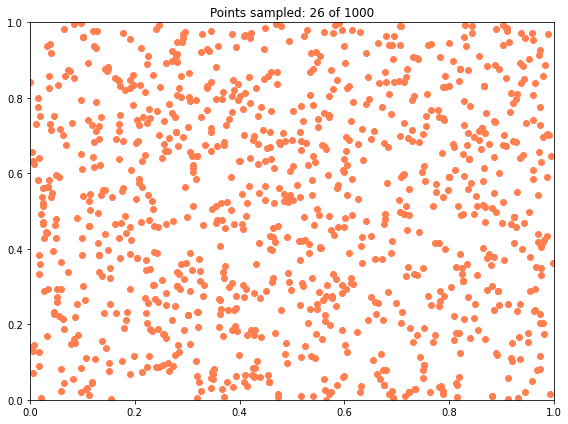

In [5]:
N_samples = 1000

points = np.zeros((2, N_samples))

fig = plt.figure(figsize=(8,6))
ax = plt.axes()

points = unif_square(N_samples)
ax.scatter(points[0,0], points[1,0], c="coral")
ax.set_xlim(0,1)
ax.set_ylim(0,1)
ax.set_title(f"Points sampled: {1} of {N_samples}")
plt.tight_layout()

def animate(i):
  ax.scatter(points[0,25*i:25*(i+1)], points[1,25*i:25*(i+1)], c="coral")
  ax.set_xlim(0,1)
  ax.set_ylim(0,1)
  ax.set_title(f"Points sampled: {25*i+1} of {N_samples}")
  plt.tight_layout()

ani = FuncAnimation(fig, animate, range(1,int(N_samples/25)))
ani.save("Uniform.gif", writer="pillow", fps=10, dpi=1000)

In [6]:
def gauss_square(samples, x1=0, x2=1, x3=0, x4=1, mu_1=0.5, mu_2=0.5, sigma_1=0.5/3, sigma_2=0.5/3):
  arr_samples = np.zeros((2, samples))
  for i in range(samples):
    in_square = False
    while not in_square:
      x = np.random.normal(loc=mu_1, scale=sigma_1)
      y = np.random.normal(loc=mu_2, scale=sigma_2)

      if x1 < x < x2 and x3 < y < x4:
        in_square = True

    arr_samples[:, i] = x, y

  return arr_samples

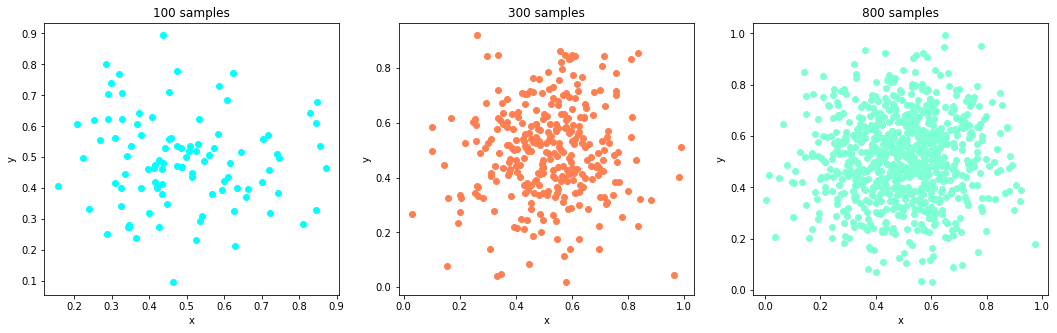

In [7]:
num_samples = (100, 300, 800)
colors = ("aqua", "coral", "aquamarine")
fig, ax = plt.subplots(1, 3, figsize = (18, 5))

for i in range(3):

  x, y = gauss_square(num_samples[i])

  ax[i].scatter(x, y, c=colors[i])
  ax[i].set_title(f"{num_samples[i]} samples")
  ax[i].set_xlabel("x")
  ax[i].set_ylabel("y")

plt.savefig("GaussianSquare1.pdf")
plt.show()

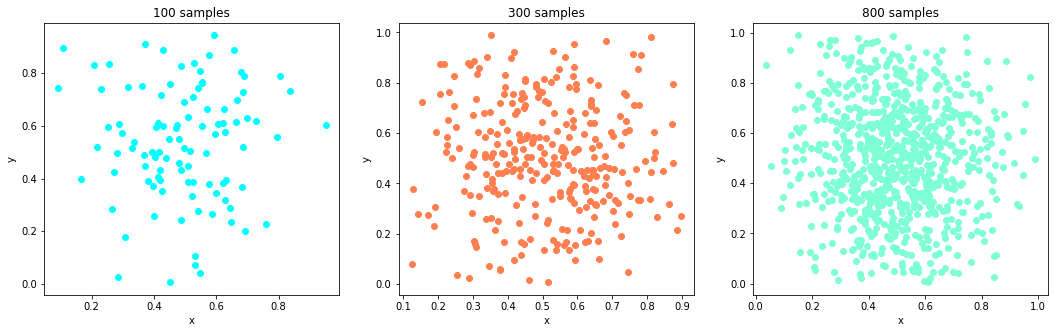

In [8]:
num_samples = (100, 300, 800)
colors = ("aqua", "coral", "aquamarine")
fig, ax = plt.subplots(1, 3, figsize = (18, 5))

for i in range(3):

  x, y = gauss_square(num_samples[i], sigma_2=0.5/2)

  ax[i].scatter(x, y, c=colors[i])
  ax[i].set_title(f"{num_samples[i]} samples")
  ax[i].set_xlabel("x")
  ax[i].set_ylabel("y")

plt.savefig("GaussianSquare2.pdf")
plt.show()

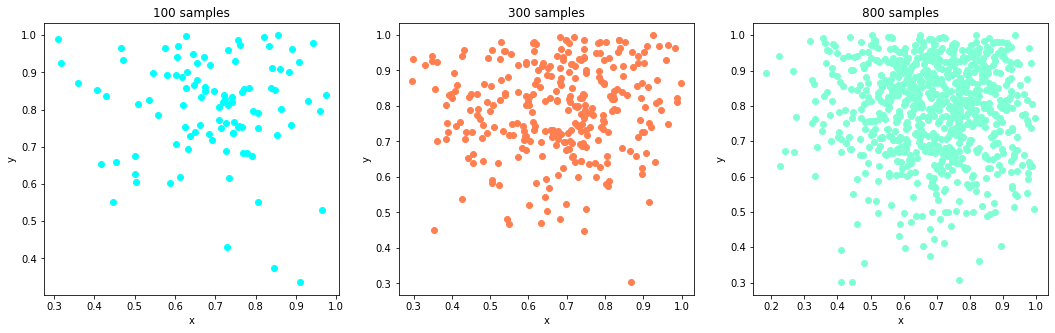

In [9]:
num_samples = (100, 300, 800)
colors = ("aqua", "coral", "aquamarine")
fig, ax = plt.subplots(1, 3, figsize = (18, 5))

for i in range(3):

  x, y = gauss_square(num_samples[i], mu_1=0.7, mu_2=0.85)

  ax[i].scatter(x, y, c=colors[i])
  ax[i].set_title(f"{num_samples[i]} samples")
  ax[i].set_xlabel("x")
  ax[i].set_ylabel("y")

plt.savefig("GaussianSquare3.pdf")
plt.show()

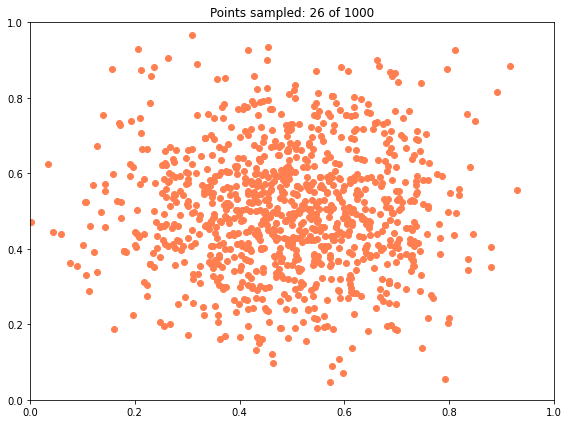

In [10]:
N_samples = 1000

points = np.zeros((2, N_samples))

fig = plt.figure(figsize=(8,6))
ax = plt.axes()

points = gauss_square(N_samples)
ax.scatter(points[0,0], points[1,0], c="coral")
ax.set_xlim(0,1)
ax.set_ylim(0,1)
ax.set_title(f"Points sampled: {1} of {N_samples}")
plt.tight_layout()

def animate(i):
  ax.scatter(points[0,25*i:25*(i+1)], points[1,25*i:25*(i+1)], c="coral")
  ax.set_xlim(0,1)
  ax.set_ylim(0,1)
  ax.set_title(f"Points sampled: {25*i+1} of {N_samples}")
  plt.tight_layout()

ani = FuncAnimation(fig, animate, range(1,int(N_samples/25)))
ani.save("GaussianGIF.gif", writer="pillow", fps=10, dpi=1000)

In [13]:
def uniform_circle1(k_samples, R=1, center=(0, 0)):
  samples = np.zeros((k_samples, 2))
  for k in range(k_samples):
    u1, u2 = np.random.rand(), np.random.rand()
    r, theta = R*u1, (2*u2 - 1)*np.pi 
    samples[k] = [r*np.cos(theta), r*np.sin(theta)]

  return samples

def uniform_circle2(k_samples, R=1, center=(0, 0)):
  samples = np.zeros((k_samples, 2))
  for k in range(k_samples):
    u1, u2 = np.random.rand(), np.random.rand()
    r, theta = R*np.sqrt(u1), (2*u2 - 1)*np.pi 
    samples[k] = [r*np.cos(theta) + center[0], r*np.sin(theta) + center[1]]

  return samples

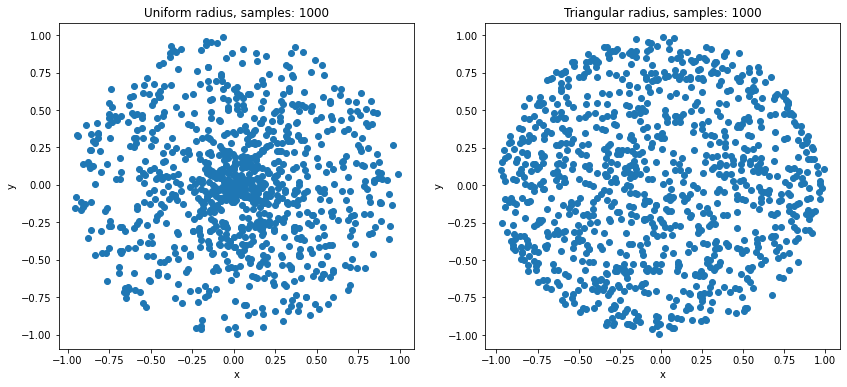

In [29]:
k_samples = 1000

samples1 = uniform_circle1(k_samples)
samples2 = uniform_circle2(k_samples)

fig, ax = plt.subplots(1, 2, figsize=(14, 6))

ax[0].scatter(samples1[:, 0], samples1[:, 1])
ax[0].set_title(f"Uniform radius, samples: {k_samples}")
ax[0].set_xlabel("x")
ax[0].set_ylabel("y")


ax[1].scatter(samples2[:, 0], samples2[:, 1])
ax[1].set_title(f"Triangular radius, samples: {k_samples}")
ax[1].set_xlabel("x")
ax[1].set_ylabel("y")

plt.savefig("CircleSampling.pdf", dpi=200)

plt.show()

In [24]:
def sample_boundary_circle(k_samples, R=1, center=(0, 0)):
  samples = np.zeros((k_samples, 2))
  for k in range(k_samples):
    u = np.random.rand()
    theta = (2*u - 1)*np.pi 

    samples[k] = [R*np.cos(theta) + center[0], R*np.sin(theta) + center[1]]

  return samples

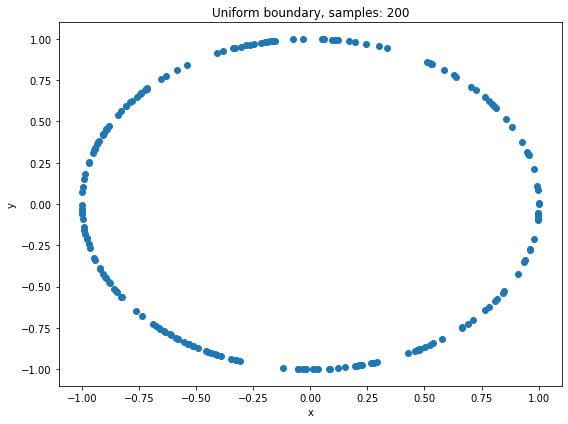

In [33]:
k_samples = 200
samples = sample_boundary_circle(k_samples)

plt.figure(figsize=(8, 6))

plt.scatter(samples[:, 0], samples[:, 1])
plt.title(f"Uniform boundary, samples: {k_samples}")
plt.xlabel("x")
plt.ylabel("y")
plt.tight_layout()

plt.savefig("UniCicleBound.pdf", dpi=200)

plt.show()

In [48]:
def uniform_ellipse(k_samples, a=1, b=1, center=(0, 0), xaxis_angle=0):

  mat_rot = np.array([[np.cos(xaxis_angle), np.sin(xaxis_angle)], 
                      [-np.sin(xaxis_angle), np.cos(xaxis_angle)]])

  samples = np.zeros((k_samples, 2))
  for k in range(k_samples):
    u1, u2 = np.random.rand(), np.random.rand()
    r, theta = np.sqrt(u1), (2*u2 - 1)*np.pi 
    point = np.array([a*r*np.cos(theta), b*r*np.sin(theta)])
    samples[k] = mat_rot @ point + np.array(center)

  return samples

def uniform_ellipse_boundary(k_samples, a=1, b=1, center=(0, 0), xaxis_angle=0):

  mat_rot = np.array([[np.cos(xaxis_angle), np.sin(xaxis_angle)], 
                      [-np.sin(xaxis_angle), np.cos(xaxis_angle)]])
  
  samples = np.zeros((k_samples, 2))
  for k in range(k_samples):
    u = np.random.rand()
    theta = (2*u - 1)*np.pi 
    point = [a*np.cos(theta), b*np.sin(theta)]
    samples[k] = mat_rot @ point + np.array(center)

  return samples

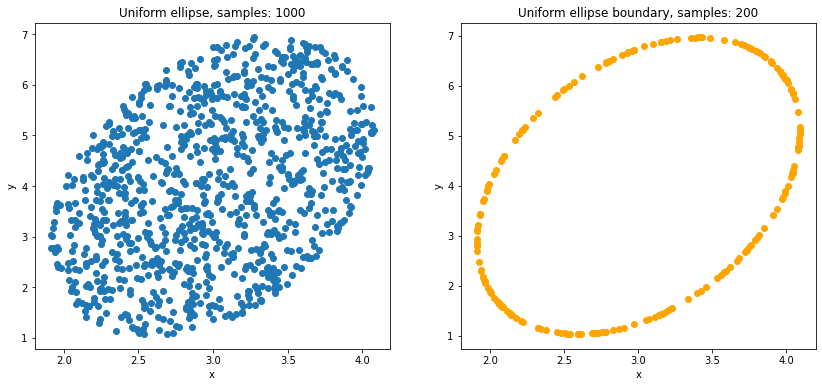

In [50]:
k_samples1 = 1000
k_samples2 = 200
a, b, center, angle = 3, 1, (3, 4), 30 

samples1 = uniform_ellipse(k_samples1, a, b, center, angle)
samples2 = uniform_ellipse_boundary(k_samples2, a, b, center, angle)

fig, ax = plt.subplots(1, 2, figsize=(14, 6))

ax[0].scatter(samples1[:, 0], samples1[:, 1])
ax[0].set_title(f"Uniform ellipse, samples: {k_samples1}")
ax[0].set_xlabel("x")
ax[0].set_ylabel("y")


ax[1].scatter(samples2[:, 0], samples2[:, 1], c="orange")
ax[1].set_title(f"Uniform ellipse boundary, samples: {k_samples2}")
ax[1].set_xlabel("x")
ax[1].set_ylabel("y")

plt.savefig("EllipseSampling.pdf", dpi=200)

plt.show()